In [1]:
from hilbert_curve import * 
from descriptors import sift_descriptor
from PIL import Image
import numpy as np
import cv2 as cv
from scipy.stats import skew, kurtosis, entropy, energy_distance
import matplotlib.pyplot as plt
import numpy.ma as ma

In [2]:
def pixel_values(img, curve_coordinates):

    curve_pixels = []
    np_img = np.asarray(img)
    
    for coord in curve_coordinates:
        curve_pixels.append(np_img[coord[1], coord[0]])
    
    return curve_pixels

# Descritores da Imagem

### Leitura da imagem em escala de cinza

In [3]:
# img = Image.open('../img/clean-bg/motorbike/image_0001.jpg').convert('L')
img_rgb = Image.open('../img/clean-bg/motorbike/image_0016.jpg')#.convert('L')
img = img_rgb.convert('L')

print(np.asarray(img_rgb).shape)
print(np.asarray(img).shape)

(153, 263, 3)
(153, 263)


### Curva de Hilbert e Região de Interesse

#### Curva de Hilbert

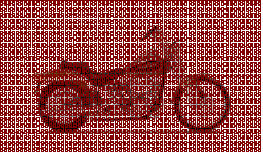

In [4]:
n = min(img.size)
curve_coordinates = hilbert_order(n, img.size)
draw_curve_on_img(img_rgb, curve_coordinates)

#### Detecção dos pontos de interesse

In [5]:
kp_list, _ = sift_descriptor(np.asarray(img))
print(f'{len(kp_list)} pontos de interesse')

170 pontos de interesse


#### Região de interesse para N pontos de interesse

In [6]:
kp_index = 0
roi_list = []
n_keypoints = len(kp_list)

while kp_index < n_keypoints:

    try:
        kp = kp_list[kp_index]
    except:
        print(kp_index)
    # Coordenadas do kp
    (x, y) = (int(kp.pt[0]), int(kp.pt[1]))
    
    # Pixels e coordenadas da região de interesse de kp
    roi_pixels, roi_coordinates = roi_curve(img, curve_coordinates, kp)

    neighborhood = [
        (x-1,y), (x+1,y), (x,y-1), (x,y+1), 
#         (x+1, y+1), (x+1, y-1), (x-1, y-1), (x-1, y+1)
        ]

    # Se não encontra a coordenada de kp na curva, verifica a vizinhança-4 de kp
    i=0
    while roi_pixels is None and i < len(neighborhood):

        kp = neighborhood[i]
        roi_pixels, roi_coordinates = roi_curve(img, curve_coordinates, kp)
        i += 1
        
    if roi_pixels is not None:
        roi_list.append((roi_pixels, roi_coordinates))
    
    kp_index += 1

In [7]:
print(f'{len(roi_list)} regiões de interesse, cada uma com {len(roi_list[0][0])} pixels.')

157 regiões de interesse, cada uma com 128 pixels.


### Descrição de uma Região de Interesse

In [8]:
roi = roi_list[50]

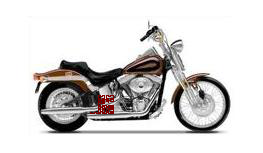

In [9]:
draw_roi = img_rgb.copy()
draw = ImageDraw.Draw(draw_roi)
draw.line(list(roi[1].flatten()), width=1, fill=128)
draw_roi

In [10]:
#draw_roi.save('../img/hilbert/descriptor.png')

### Gradiente de intensidade

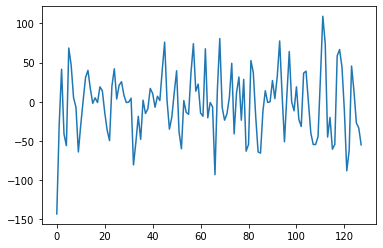

In [11]:
gradient = np.gradient(roi[0])
plt.plot(gradient)

### Histograma de intensidade

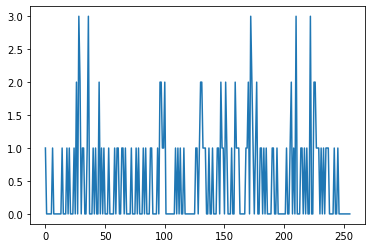

In [12]:
h = np.zeros(256)
for i in range(256):
    h[i] = int(np.count_nonzero(np.asarray(roi[0])==i))
plt.plot(h)

### Medidas estatísticas  

In [13]:
# Distribuição de probabilidade
prob_dist = h/np.sum(h) 
    
#     Desvio padrão
std1 = np.std(roi[0])
std2 = np.std(gradient)
            
#     Assimetria
assi1 = skew(roi[0])
assi2 = skew(gradient)
            
#     Curtose
curt = kurtosis(prob_dist)
    
#     Entropia
entr = entropy(prob_dist)
    
desc = np.asarray([std1,std2,assi1,assi2,curt,entr])

In [14]:
desc

array([69.41777257, 41.43593276, -0.17895577, -0.13552072,  1.625     ,
        4.53916942])